## Вероятностная рейтинг-система для спортивного “Что? Где? Когда?” (ЧГК)

В спортивном “Что? Где? Когда?” соревнующиеся команды отвечают на одни и те же вопросы. После минуты обсуждения команды записывают и сдают свои ответы на карточках; побеждает тот, кто ответил на большее число вопросов. Турнир обычно состоит из нескольких десятков вопросов (обычно 36 или 45, иногда 60, больше редко). Часто бывают синхронные турниры, когда на одни и те же вопросы отвечают команды на сотнях игровых площадок по всему миру, т.е. в одном турнире могут играть сотни, а то и тысячи команд. Соответственно, нам нужно:
* построить рейтинг-лист, который способен нетривиально предсказывать результаты будущих турниров;
* при этом, поскольку ЧГК — это хобби, и контрактов тут никаких нет, игроки постоянно переходят из команды в команду, сильный игрок может на один турнир сесть поиграть за другую команду и т.д.; поэтому единицей рейтинг-листа должна быть не команда, а отдельный игрок;
* а что сильно упрощает задачу и переводит её в область домашних заданий на EM-алгоритм — это характер данных: начиная с какого-то момента, в базу результатов начали вносить все повопросные результаты команд, т.е. в данных будут записи вида “какая команда на какой вопрос правильно ответила”.

Загрузим данные и посмотрим на них

In [89]:
import json
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from scipy.stats import spearmanr, kendalltau
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder

In [2]:
tournaments = pickle.load(open("chgk/tournaments.pkl", "rb"))
results = pickle.load(open("chgk/results.pkl", "rb"))
players = pickle.load(open("chgk/players.pkl", "rb"))

In [3]:
train_tour = {k:v for k,v in tournaments.items() if v["dateStart"][:4] == "2019"}
test_tour  = {k:v for k,v in tournaments.items() if v["dateStart"][:4] == "2020"}

In [4]:
results[5465][0]["mask"], [p["player"]["id"] for p in results[5465][0]["teamMembers"]]

('010111101111010110001000111101011010111011000111111111110011110100001010101111111111011110',
 [28751, 30152, 30270, 27822, 27403, 4270])

In [5]:
all_players = set()
for tour_id in train_tour:
    for team in results[tour_id]:
         all_players.update(set([p["player"]["id"] for p in team["teamMembers"]]))
            
test_players = set()
for tour_id in test_tour:
    for team in results[tour_id]:
         test_players.update(set([p["player"]["id"] for p in team["teamMembers"]]))

*TASK*: Постройте baseline-модель на основе линейной или логистической регрессии, которая будет обучать рейтинг-лист игроков. Замечания и подсказки:

* повопросные результаты — это фактически результаты броска монетки, и их предсказание скорее всего имеет отношение к бинарной классификации;
*  в разных турнирах вопросы совсем разного уровня сложности, поэтому модель должна это учитывать; скорее всего, модель должна будет явно обучать не только силу каждого игрока, но и сложность каждого вопроса;
* для baseline-модели можно забыть о командах и считать, что повопросные результаты команды просто относятся к каждому из её игроков.

*ANS*:

Для baseline будем считать, что игрок ответил на вопрос, если на вопрос ответила его команда.

Для начала вычислим сложность каждого вопроса, как отношение количества игроков ответивших на вопрос к количеству игроков в турнире (чем оно меньше, тем вопрос сложнее)

In [6]:
Q = dict()
X = {"id_pl":[], "q_id":[], "y":[]}
for tour_id in train_tour.keys():
    for i in range(999):
        
        k = 0
        N = 0
        stop = True
        q_id = f"{tour_id}_{i}"
        
        for comand in results[tour_id]:
            if 'mask' in comand.keys() and comand["mask"] is not None and len(comand["mask"]) > i:
                
                players = [p["player"]["id"] for p in comand["teamMembers"]]
                if comand["mask"][i] == "1":
                    k += len(players)
                    
                for player in players:
                    X["id_pl"].append(player)
                    X["q_id"].append(q_id)
                    X["y"].append(1 if comand["mask"][i] == "1" else 0)
                    
                N += len(players)
                stop = False
                
        if N != 0:
            k = k/N
        else:
            if stop:
                break
            continue
            
        Q[q_id] = k
        if stop:
            break
            
Q = pd.DataFrame({"q_id":list(Q.keys()),"q":list(Q.values())})
X = pd.DataFrame(X)
X = X.merge(Q, on='q_id')

Посмотрим на распределение СВ сложность вопроса

/Users/baduk/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


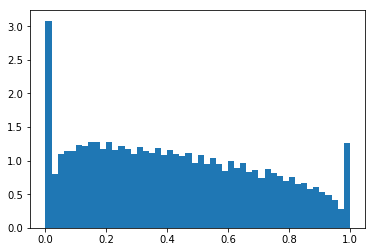

In [7]:
bins=50
_=plt.hist(Q["q"], bins=bins, normed=True)

Найдем ряд распределения для СВ -- сложность вопроса $q \sim Q$

In [8]:
q = Q["q"].values
N = len(q)
final = 1 + 1e-10
grid = np.hstack((np.linspace(0, final, bins+1)[:-1].reshape(-1,1), np.linspace(0, final, bins+1)[1:].reshape(-1,1)))

In [9]:
probs = []
x = grid.mean(axis=1)
for T in grid:
    prob = len(q[(q>=T[0]) & (q<T[1])])/N
    probs.append(prob)
probs = np.array(probs)

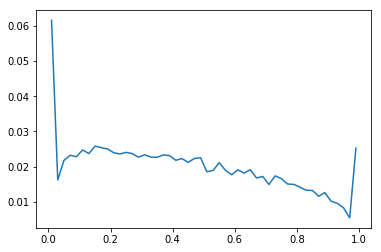

In [10]:
plt.plot(x, probs)

In [11]:
print(sum(probs))

1.0


Найдем рейтинг каждого игрока.

Обучим логистичесскую регрессию предсказывать вероятность $p_i$ ответить игроком на вопрос используя единственный признак - сложность вопроса.

Тогда так как $p_i$, будет функцией от реализации случайной велечины $q_i \sim Q$, можем найти мат ожидание $p_i$ по распределению $Q$. $p_i = \sigma(\theta q_i + \theta_0)$.

$E[p] = \sum_{q_i \in Q} q_ip(q_i)$

Это мат ожидание и будем считать рейтингом игрока. У него также есть вероятностный смысл: вероятность ответить на случайный вопрос из базы вопросов. Это понадобится для ранжирования команд.

In [12]:
X["rating_player"] = [0]*len(X)

In [310]:
clf = LogisticRegression(C=100, solver="lbfgs")
for player in tqdm(X[X.rating_player == 0]["id_pl"].drop_duplicates().values):
    q_feat = X[X.id_pl==player]["q"].values.reshape(-1,1)
    y = X[X.id_pl==player]["y"].values
    if np.unique(y).shape[0] > 1:
        clf.fit(q_feat,y)
        predict_ans = clf.predict_proba(x.reshape(-1,1))[:,1]
        rating = predict_ans @ probs
    else:
        rating = y[0]
    X.loc[X["id_pl"] == player, "rating_player"] = rating

In [195]:
#X.to_csv("data_with_rating.csv", index=False)
#Ссылка на данные:
#https://drive.google.com/file/d/1ZwgdnhDOof-LsiSQaEicMGCk_DHArDbK/view?usp=sharing
X = pd.read_csv("data_with_rating.csv")

In [13]:
raitings = {}
x_players = X.drop_duplicates("id_pl")[["id_pl","rating_player"]]
for player in tqdm(x_players.id_pl):
    raitings[player] = x_players[x_players.id_pl == player]["rating_player"].values[0]

In [17]:
mean_rating = x_players["rating_player"].values.mean()

*TASK*: Качество рейтинг-системы оценивается качеством предсказаний результатов турниров. Но сами повопросные результаты наши модели предсказывать вряд ли смогут, ведь неизвестно, насколько сложными окажутся вопросы в будущих турнирах; да и не нужны эти предсказания сами по себе. Поэтому:
* предложите способ предсказать результаты нового турнира с известными составами, но неизвестными вопросами, в виде ранжирования команд;
* в качестве метрики качества на тестовом наборе давайте считать ранговые корреляции Спирмена и Кендалла (их можно взять в пакете ​scipy)​между реальным ранжированием в результатах турнира и предсказанным
1 моделью, усреднённые по тестовому множеству турниров.

*ANS*:

Отранжируем команды по рейтингу (т.е по вероятности ответить на случайный вопрос из базы). 
Вероятность команды ответить на вопрос вычислим из рейтинга состава команды: 
    
$R = 1 - \prod\limits_{i\in T} (1 - r_i)$

* $r_i$ - рейтинг $i$ - го игрока 
* $T$ - состав команды
* $R$ - рейтинг команды

In [18]:
def command_rank(command):
    inv_rate = 1
    players = [p["player"]["id"] for p in command]
    for player in players:
        if player in raitings.keys():
            inv_rate = inv_rate * (1-raitings[player])
        else:
            inv_rate = inv_rate * (1 - mean_rating)
    return 1 - inv_rate

In [21]:
SPEARMAN = []
KENDALL = []
for tour in test_tour.keys():
    
    ranks_true = []
    ranks_pred = []
    
    for command in results[tour]:
        if 'position' in command.keys() and 'teamMembers' in command.keys():
            ranks_true.append(-command['position'])
            ranks_pred.append(command_rank(command['teamMembers']))
    spearman_coef = spearmanr(ranks_true, ranks_pred)[0]
    kendall_coef = kendalltau(ranks_true, ranks_pred)[0]
    
    if not np.isnan(spearman_coef):
        SPEARMAN.append(spearman_coef)
    if not np.isnan(kendall_coef):
        KENDALL.append(kendall_coef)
        
print(f"Mean spearman coeff: {np.mean(SPEARMAN)}, mean kendall coeff: {np.mean(KENDALL)}")

Mean spearman coeff: 0.6672880916086196, mean kendall coeff: 0.5154203218219204


*TASK*: Теперь главное: ЧГК — это всё-таки командная игра. Поэтому:
* предложите способ учитывать то, что на вопрос отвечают сразу несколько игроков; скорее всего, понадобятся скрытые переменные; не стесняйтесь делать упрощающие предположения, но теперь переменные “игрок X ответил на вопрос Y” при условии данных должны стать зависимыми для игроков одной и той же команды;
* разработайте EM-схему для обучения этой модели, реализуйте её в коде;
* обучите несколько итераций, убедитесь, что целевые метрики со временем растут (скорее всего, ненамного, но расти должны), выберите лучшую модель, используя целевые метрики.

*ANS*:

Нам понадобятся id команд

In [80]:
command_id = []
for tour_id in train_tour.keys():
    for i in range(999):
        
        for comand in results[tour_id]:
            if 'mask' in comand.keys() and comand["mask"] is not None and len(comand["mask"]) > i:             
                players = [p["player"]["id"] for p in comand["teamMembers"]]                   
                for player in players:
                    command_id.append(comand["team"]["id"])
                stop = False              
            
        if stop:
            break

In [196]:
X["command_id"] = command_id

In [186]:
p_init = X["rating_player"].values

In [258]:
def e_step(p, X):
    X = X.copy()
    X["inv_p"] = 1 - p
    p_command = X[['command_id', 'q_id', 'inv_p']].groupby(by=['command_id', 'q_id'], 
                                                        sort=False, as_index=False).prod()
    p_command["p"] = 1 - p_command["inv_p"].values
    p_command.drop(['inv_p'], axis=1, inplace=True)
    X = X.merge(p_command, on=["command_id", "q_id"])
    expect = p / X["p"].values
    expect[X["y"].values == 0] = 0
    return expect

In [262]:
expect = e_step(p_init, X)

/Users/baduk/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


In [263]:
print(np.mean(p_init[X.y.values > 0] - expect[X.y.values > 0]))

-0.02244156649016441


In [280]:
ohe = OneHotEncoder(handle_unknown='ignore')
ohe.fit(X[['id_pl', 'q_id']])
X_spars_feat = enc.transform(X[['id_pl', 'q_id']])
zero_counts = np.array((X_spars_feat != 0).sum(axis=0)).reshape(-1)

In [281]:
def sigma(x, theta):
    return 1 / (1 + np.exp(-x @ theta))

In [288]:
def m_step(X_spars_feat, theta, expect, n_iters=20, a=1):
    theta = theta.copy()
    for _ in range(n_iters):
        p = sigma(X_spars_feat, theta)
        grad = X_spars_feat.T @ (expect * (1 - p) - (1 - expect) * p) / zero_counts
        theta += a * grad
    return sigma(X_spars_feat, theta), theta

In [289]:
theta = np.random.uniform(0,1,X_spars_feat.shape[1])

In [290]:
m_step(X_spars_feat, theta, expect, n_iters=1, a=1)

(array([0.72908674, 0.72476851, 0.63408571, ..., 0.64200826, 0.62205462,
        0.55605115]),
 array([-0.05929414,  0.65199852,  0.23710553, ..., -0.0181761 ,
         0.00491586,  0.41882365]))

In [301]:
N = 2
#p = p_init
for i in tqdm(range(N)):
    expect = e_step(p, X)
    p, theta = m_step(X_spars_feat, theta, expect)
    print(f'cross entropy: {np.mean(expect * np.log(p) + (1 - expect) * np.log(1 - p))}')

cross entropy: -0.31434422839686776
cross entropy: -0.31178599966163456



In [298]:
ohe.get_feature_names()

array(['x0_15', 'x0_16', 'x0_23', ..., 'x1_6255_97', 'x1_6255_98',
       'x1_6255_99'], dtype=object)